## PROJEKT 1 - Modelowanie Układów Przepływowych 2025/26 dla Fizyki Technicznej AGH



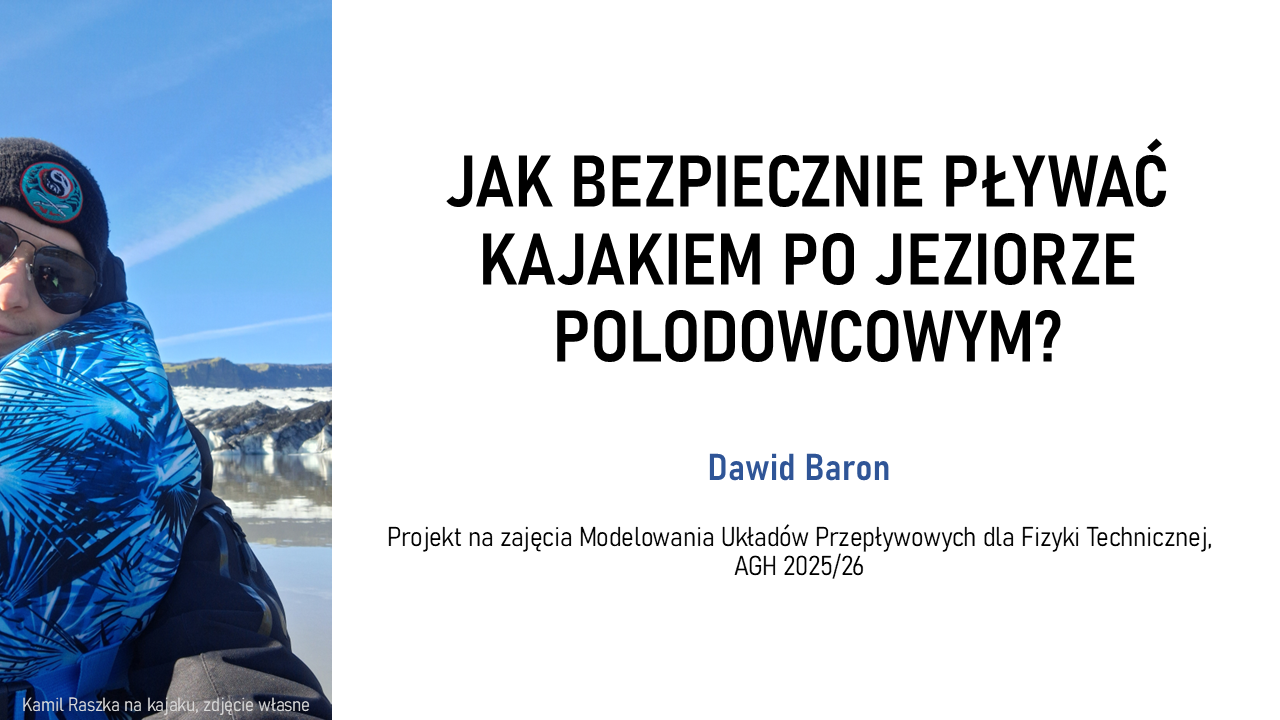

In [58]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [59]:
import os
os.environ["NUMBA_THREADING_LAYER"] = 'omp'

### 0. Import niezbędnych pakietów Pythona

In [60]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

### 1. Opis rozwiązywanego problemu

Podczas wyjazdu na Islandię z *SKNF Bozon*, prowadząc pomiary w rejonie jezior polodowcowych, zmuszeni byliśmy do wykorzystywania kajaka jako głównego środka transportu po akwenie. W cieplejsze dni obserwowaliśmy, jak fragmenty lodowca odrywają się od jego czoła i wpadają do wody, wywołując wyraźne zaburzenia poziomu zwierciadła jeziora oraz propagację fal w jego obrębie.

Celem niniejszego projektu jest numeryczna symulacja zaburzenia wody powstałego w wyniku wpadnięcia do jeziora kawałka lodowca oraz próba odpowiedzi na pytanie, w jaki sposób najlepiej ustawić się kajakiem względem powstającej fali, aby zminimalizować ryzyko wywrócenia jednostki pływającej.

W projekcie przyjęto następujące założenia:

*   Dno jeziora jest przybliżone **jako dolina u-kształtna** i opisane funkcją sinusoidalną wzdłuż jednej z osi poziomych.
*   Kajak znajduje się w pozycji optymalnej względem nadchodzącej fali wtedy, gdy jest ustawiony prostopadle do frontu fali, co odpowiada ustawieniu **równoległemu do wektora prędkości** jej propagacji w danym punkcie.
*   Najbezpieczniejsze do pływania są miejsca z **jak najmniejszą prędkością** propagacji fali
*   Wpadający do wody odłamek lodowca pozostawia po sobie zaburzenie poziomu wody o geometrii falki "mexican hat"
*   Fragment lodowca wpada do jeziora w miejscu, gdzie jego głębokość jest największa

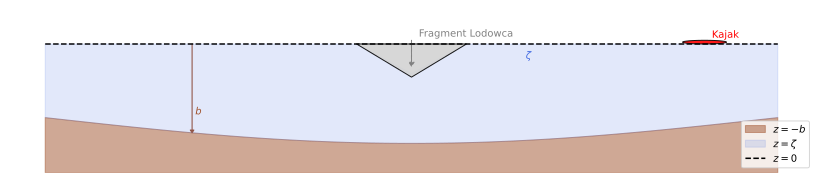

In [61]:
pyplot.figure(figsize=(14.5, 3))
pyplot.axis('off')

x = np.linspace(0, 10, 400)

b0 = -2.0
amp_b = 0.7
b = b0 - amp_b * np.sin(np.pi * x / x.max())

zeta = np.zeros_like(x)


x0    = (x[0] + x[-1]) / 2
width = 1.5
amp_z = 0.8

mask = np.abs(x - x0) <= width / 2
zeta[mask] = -amp_z * (1 - np.abs(x[mask] - x0) / (width / 2))

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

color = 'sienna'
pyplot.fill_between(
    x, b, b.min() - 0.8,
    color=color,
    label=r'$z=-b$',
    alpha=.5
)
ix = 80
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(" $b$", xy=(x[ix], b[ix] + 0.5), color=color)


color = 'royalblue'
pyplot.fill_between(
    x, zeta, b,
    color=color,
    alpha=.15,
    label=r'$z=\zeta$'
)
ix = 260
pyplot.arrow(x[ix], 0, 0, zeta[ix], color=color, **arrow_kwargs)
pyplot.annotate(r" $\zeta$", xy=(x[ix], zeta[ix] - 0.4), color=color)


color = 'black'
pyplot.plot(x, np.zeros_like(x), linestyle='--', color=color, label=r'$z=0$')


ice_x = [x0 - width/2, x0 + width/2, x0]
ice_z = [0.0, 0.0, -0.9]
pyplot.fill(ice_x, ice_z, color='lightgray', edgecolor='k', alpha=0.9)
pyplot.annotate("Fragment Lodowca", xy=(x0 + 0.1, 0.2), color='gray')


pyplot.arrow(
    x0, 0.1,
    0, -0.7,
    color='gray',
    linestyle='--',
    length_includes_head=True,
    head_width=0.07
)


kayak_center = x[-1] - 1.0
z_kayak_center = 0.05

kayak_len = 0.6
kayak_width = 0.10


theta = np.linspace(0, 2*np.pi, 100)
kayak_x = kayak_center + (kayak_len / 2) * np.cos(theta)
kayak_z = z_kayak_center + (kayak_width / 2) * np.sin(theta)

pyplot.fill(kayak_x, kayak_z, color='red', edgecolor='k', alpha=0.9)
pyplot.annotate("Kajak", xy=(kayak_center + 0.1, z_kayak_center + 0.12),
                color='red')


pyplot.ylim(b.min() - 0.8, 1.0)

pyplot.legend(loc='lower right')

show_plot('sin_bottom_glacier')


### 2. Solwer równań płytkiej wody zbudowany na bazie PyMPDATA (autor - dr Sylwester Arabas)

In [62]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, bathymetry: np.ndarray, h_initial: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

### 3. Symulacja opisanego scenariusza

W rozważanym przykładzie modelowane jest jezioro polodowcowe o uproszczonej geometrii dna i punktowym zaburzeniu powierzchni wody, odpowiadającym wpadnięciu do jeziora fragmentu lodowca.

Domena obliczeniowa ma rozmiar $200 \times 120$ komórek:
$$
\text{grid} = (n_x, n_y) = (200, 120),
$$
gdzie pierwszy indeks odpowiada kierunkowi wzdłuż jeziora ($x$), a drugi poprzecznemu ($y$). Wszystkie zmienne są dyskretyzowane na tej samej jednorodnej siatce. Wymiary jeziora fragmentu jeziora określono na 400m na 240m.

Dno jeziora opisano funkcją sinusoidalną wzdłuż osi $x$:
$$
b(x) \propto \sin(\pi x),
$$
następnie powieloną wzdłuż $y$, tak że każdy przekrój poprzeczny ma ten sam kształt. Głębokość zeskalowano tak, by maksymalna głębokość wynosiła ok.~$60\,\text{m}$.

Stan początkowy to równowaga hydrostatyczna ($\zeta = 0$), z całkowitą głębokością kolumny wody równą lokalnej batymetrii:
$$
h(x,y,t=0) = b(x,y).
$$

Na ten stan nałożono lokalne zaburzenie o kształcie falki typu mexican hat:
$$
\psi(r) = \frac{2}{\sqrt{3}\,\pi^{1/4}}\,(1 - r^{2})\,\exp\!\left(-\frac{1}{2}r^{2}\right),
$$
gdzie $r$ jest odległością znormalizowaną w eliptycznym układzie współrzędnych. Początkowo prędkości przepływu są równe zeru.

Przyjęto przyspieszenie ziemskie
$$
g = 10\,\text{m s}^{-2},
$$
oraz krok czasowy $\Delta t$ spełniający
$$
\frac{\Delta t}{\Delta x} = \frac{\Delta t}{\Delta y} = 0{,}05,
$$
co zapewnia spełnienie warunku CFL dla rozpatrywanych głębokości i prędkości. Symulację prowadzono przez $400$ kroków czasowych, co pozwala zaobserwować formowanie się fali, jej propagację i odbicia od brzegów. Dla czytelności wizualizacji pole wektorowe prędkości rysowano dla co drugiego punktu siatki.



In [63]:
# --- SIATKA 100 x 60 ---
grid1 = (200, 120)
nx1, ny1 = grid1

x = np.linspace(0, 1, nx1)
v_profile = np.sin(np.pi * x)
bathymetry1 = np.tile(v_profile[:, None], (1, ny1))

h_initial1 = bathymetry1.copy()

x0 = nx1 // 2
y0 = ny1 - 1

X1, Y1 = np.meshgrid(np.arange(nx1), np.arange(ny1), indexing='ij')

rx1 = nx1 / 12.0
ry1 = ny1 / 6.0
r2_1 = ((X1 - x0) / rx1)**2 + ((Y1 - y0) / ry1)**2

mexican_hat1 = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2_1) * np.exp(-0.5 * r2_1)
mexican_hat1 /= np.max(np.abs(mexican_hat1))
amplitude = 0.05
h_initial1 -= amplitude * mexican_hat1

output1 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial1,
    bathymetry=bathymetry1
)(
    nt=800,
    g=10,
    dt_over_dxy=(0.05, 0.05),
    outfreq=12
)

### 4. Wizualizacja

In [75]:
depth_scale = 60.0   # [m]

def plot_coarse(frame, *, zlim=(-.25, .25)):

    psi = output1['h'][frame] - bathymetry1

    psi_m   = depth_scale * psi
    bathy_m = depth_scale * bathymetry1
    zlim_m  = (depth_scale * zlim[0], depth_scale * zlim[1])

    xi, yi = np.indices(psi.shape)
    nx, ny = psi.shape

    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))


    ax.plot_wireframe(xi + .5, yi + .5, psi_m, color='blue', linewidth=.5)

    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"Powierzchnia jeziora wraz z modelem dna, t / Δt = {frame}",
        zlabel=r"$\zeta$ [m]"
    )

    dx = 2.0
    dy = 2.0


    xticks_idx = np.linspace(0, nx, 5)
    yticks_idx = np.linspace(0, ny, 5)


    xtick_labels = [(t - nx/2) * dx for t in xticks_idx]
    ytick_labels = [(t - ny/2) * dy for t in yticks_idx]

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.set_xticklabels([f"{val:.0f}" for val in xtick_labels])
    ax.set_yticklabels([f"{val:.0f}" for val in ytick_labels])


    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    cbar = pyplot.colorbar(
        ax.contourf(xi + .5, yi + .5, bathy_m, zdir='z', offset=zlim_m[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry [m]', location='left'
    )
    cbar.ax.invert_yaxis()

    return fig


fig0 = plot_coarse(0)
fig0.savefig("Powierzchnia_plynu2D_t0.png", bbox_inches="tight", dpi=200)


show_anim(
    plot_coarse,
    range(len(output1['h'])),
    gif_file="Powierzchnia_plynu2D.gif"
)


Output hidden; open in https://colab.research.google.com to view.


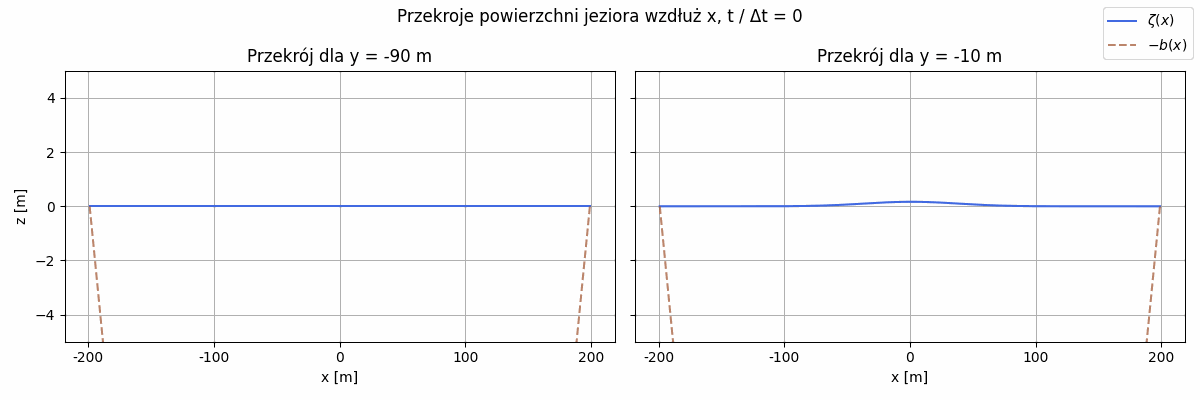

Button(description='Przekroje_y15_y55.gif', style=ButtonStyle())

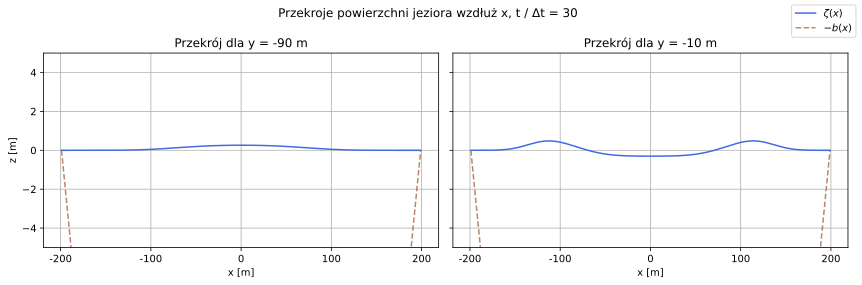

In [78]:
depth_scale = 60.0  # [m]

def plot_two_cross_sections(frame, ys=(15, 55)):

    psi = output1['h'][frame] - bathymetry1.copy()

    psi_m   = depth_scale * psi
    bathy_m = depth_scale * bathymetry1

    nx, ny = psi.shape
    x = np.arange(nx) + 0.5

    fig, axes = pyplot.subplots(1, 2, figsize=(12, 4), sharey=True)

    dx = 2.0

    xticks_idx = np.linspace(0, nx, 5)
    xtick_labels = [(t - nx/2) * dx for t in xticks_idx]

    for ax, y_idx in zip(axes, ys):

        zeta_slice   = psi_m[:, y_idx]
        bottom_slice = -bathy_m[:, y_idx]

        ax.plot(x, zeta_slice, label=r'$\zeta(x)$', color='royalblue')
        ax.plot(x, bottom_slice, '--', label=r'$-b(x)$', color='sienna', alpha=0.7)

        ax.set_xlabel('x [m]')
        ax.grid(True)
        ax.set_title(f'Przekrój dla y = {2*(y_idx-60)} m')

        ax.set_xticks(xticks_idx)
        ax.set_xticklabels([f"{val:.0f}" for val in xtick_labels])

    axes[0].set_ylabel('z [m]')
    axes[0].set_ylim(-5,5)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    fig.suptitle(f'Przekroje powierzchni jeziora wzdłuż x, t / Δt = {frame}')
    fig.tight_layout()

    return fig


fig0 = plot_two_cross_sections(30)
fig0.savefig("Przekroje_y15_y55.png", bbox_inches="tight", dpi=200)

show_anim(plot_two_cross_sections, range(len(output1['h'])), gif_file="Przekroje_y15_y55.gif")



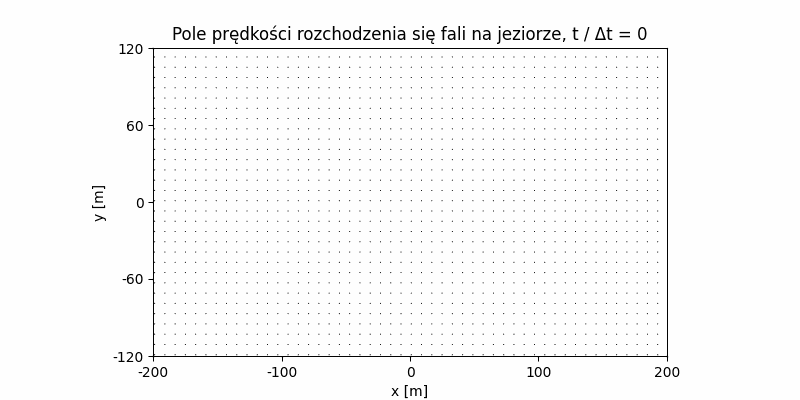

Button(description='predkosci_vec.gif', style=ButtonStyle())

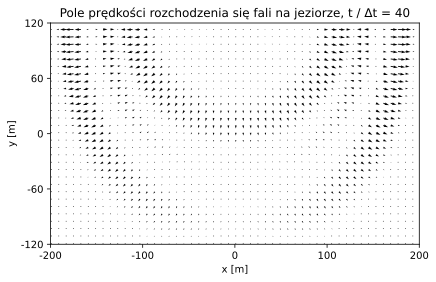

In [80]:
def plot_velocity(frame, eps=1e-7, step=4, arrow_scale=60.0):

    h  = output1['h'][frame]
    uh = output1['uh'][frame]
    vh = output1['vh'][frame]

    nx, ny = h.shape

    u = np.zeros_like(h)
    v = np.zeros_like(h)
    mask = h > eps
    u[mask] = uh[mask] / h[mask]
    v[mask] = vh[mask] / h[mask]

    x = np.arange(nx) + 0.5
    y = np.arange(ny) + 0.5

    X, Y = np.meshgrid(x, y, indexing='ij')

    fig, ax = pyplot.subplots(figsize=(8, 4))

    slx = slice(0, nx, step)
    sly = slice(0, ny, step)

    U_plot = u[slx, sly] * arrow_scale
    V_plot = v[slx, sly] * arrow_scale

    ax.quiver(
        X[slx, sly],
        Y[slx, sly],
        U_plot,
        V_plot,
        angles='xy',
        scale_units='xy',
        scale=1
    )

    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_aspect('equal')
    ax.set_title(f"Pole prędkości rozchodzenia się fali na jeziorze, t / Δt = {frame}")

    dx = 2.0
    dy = 2.0

    xticks_idx = np.linspace(0, nx, 5)
    yticks_idx = np.linspace(0, ny, 5)

    xtick_labels = [(t - nx/2) * dx for t in xticks_idx]
    ytick_labels = [(t - ny/2) * dy for t in yticks_idx]

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.set_xticklabels([f"{val:.0f}" for val in xtick_labels])
    ax.set_yticklabels([f"{val:.0f}" for val in ytick_labels])

    return fig


fig0 = plot_velocity(40)
fig0.savefig("predkosci_vec.png", bbox_inches="tight", dpi=200)

show_anim(plot_velocity, range(len(output1['h'])), gif_file="predkosci_vec.gif")


### 5. Analiza zbieżności

W celu sprawdzenia, na ile otrzymane rozwiązanie jest poprawne fizycznie i nie dominują w nim efekty numeryczne, powtórzono cały rachunek z dwukrotnie zwiększoną rozdzielczością przestrzenną oraz czasową, a także z dwukrotnie zmniejszoną prędkością dla dwa razy większej ilości kroków czasowych.

In [67]:
grid2 = (400, 240)
nx2, ny2 = grid2

x = np.linspace(0, 1, nx2)
v_profile = np.sin(np.pi * x)
bathymetry2 = np.tile(v_profile[:, None], (1, ny2))

h_initial2 = bathymetry2.copy()

x0 = nx2 // 2
y0 = ny2 - 1

X2, Y2 = np.meshgrid(np.arange(nx2), np.arange(ny2), indexing='ij')

rx2 = nx2 / 12.0
ry2 = ny2 / 6.0
r2_2 = ((X2 - x0) / rx2)**2 + ((Y2 - y0) / ry2)**2

mexican_hat2 = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2_2) * np.exp(-0.5 * r2_2)
mexican_hat2 /= np.max(np.abs(mexican_hat2))
h_initial2 -= amplitude * mexican_hat2

output2 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial2,
    bathymetry=bathymetry2
)(
    nt=1600,
    g=10,
    dt_over_dxy=(0.05, 0.05),
    outfreq=24
)


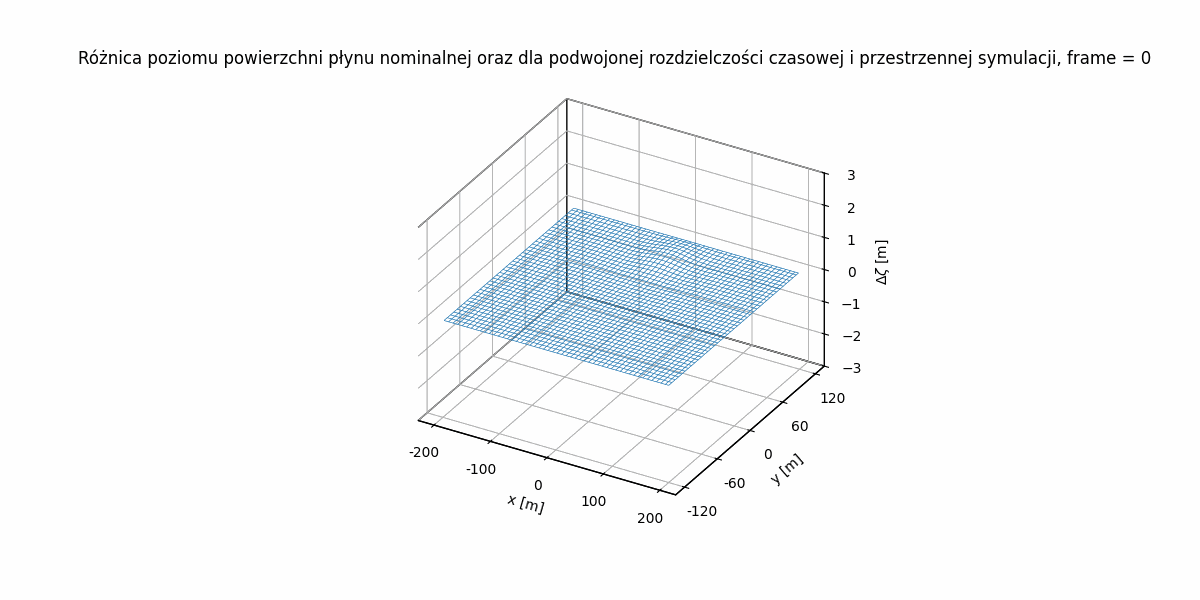

Button(description='Zbieznosc_roznica.gif', style=ButtonStyle())

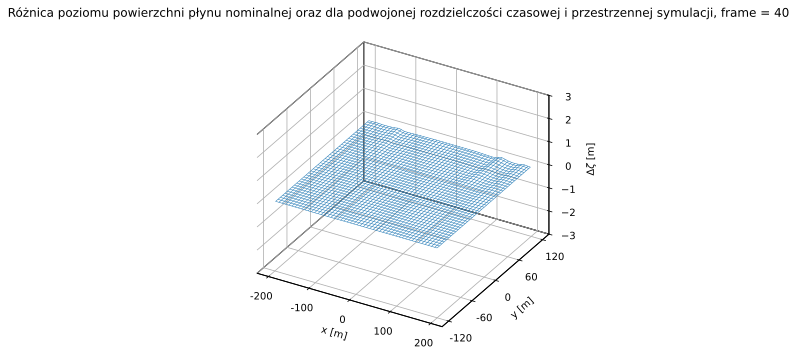

In [83]:
depth_scale = 60.0  # [m]

def plot_difference(frame, *, zlim=(-0.05, 0.05)):

    psi1 = output1['h'][frame] - bathymetry1
    psi2 = output2['h'][frame] - bathymetry2


    psi2_on_coarse = psi2[::2, ::2]


    diff_m = depth_scale * (psi2_on_coarse - psi1)

    xi, yi = np.indices(diff_m.shape)
    nx, ny = diff_m.shape

    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

    ax.plot_wireframe(xi + 0.5, yi + 0.5, diff_m, linewidth=.5)

    zlim_m = (depth_scale * zlim[0], depth_scale * zlim[1])
    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"Różnica poziomu powierzchni płynu nominalnej oraz dla podwojonej rozdzielczości czasowej i przestrzennej symulacji, frame = {frame}",
        zlabel=r"$\Delta \zeta$ [m]"
    )

    dx = 2.0
    dy = 2.0

    xticks_idx = np.linspace(0, nx, 5)
    yticks_idx = np.linspace(0, ny, 5)

    xtick_labels = [(t - nx/2) * dx for t in xticks_idx]
    ytick_labels = [(t - ny/2) * dy for t in yticks_idx]

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.set_xticklabels([f"{val:.0f}" for val in xtick_labels])
    ax.set_yticklabels([f"{val:.0f}" for val in ytick_labels])

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    return fig


fig0 = plot_difference(40)
fig0.savefig("Zbieznosc_roznica.png", bbox_inches="tight", dpi=200)

show_anim(
    plot_difference,
    range(len(output1['h'])),
    gif_file="Zbieznosc_roznica.gif"
)


In [69]:
grid3 = (200, 120)
nx3, ny3 = grid3

x = np.linspace(0, 1, nx3)
v_profile = np.sin(np.pi * x)
bathymetry3 = np.tile(v_profile[:, None], (1, ny3))

h_initial3 = bathymetry3.copy()

x0 = nx1 // 2
y0 = ny1 - 1

X3, Y3 = np.meshgrid(np.arange(nx1), np.arange(ny1), indexing='ij')

rx3 = nx3 / 12.0
ry3 = ny3 / 6.0
r2_3 = ((X3 - x0) / rx3)**2 + ((Y3 - y0) / ry3)**2

mexican_hat3 = (2.0 / (np.sqrt(3.0) * np.pi**0.25)) * (1.0 - r2_3) * np.exp(-0.5 * r2_3)
mexican_hat3 /= np.max(np.abs(mexican_hat3))
amplitude = 0.05
h_initial3 -= amplitude * mexican_hat3

output3 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial3,
    bathymetry=bathymetry3
)(
    nt=1600,
    g=10,
    dt_over_dxy=(0.025, 0.025),
    outfreq=12
)


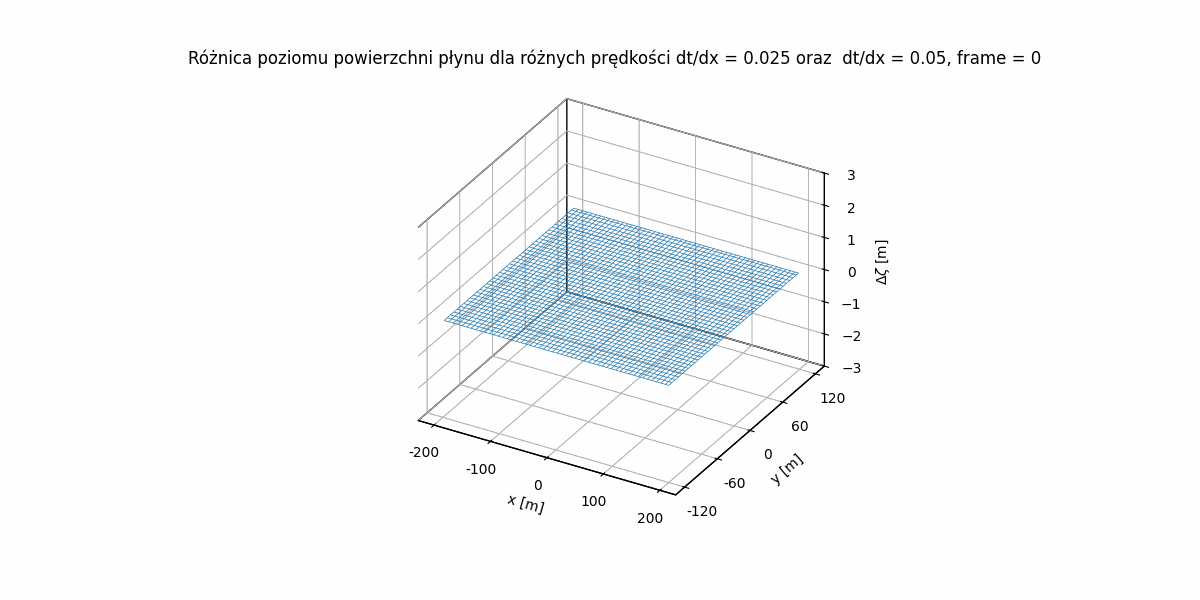

Button(description='Zbieznosc_dt_roznica.gif', style=ButtonStyle())

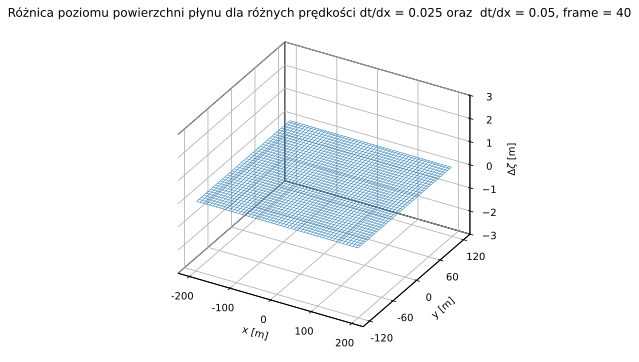

In [84]:
depth_scale = 60.0  # [m]

def plot_diff(frame, *, zlim=(-0.05, 0.05)):
    # zaburzenie z pierwszej symulacji
    psi1 = output1['h'][frame] - bathymetry1

    # zaburzenie z drugiej (mniejszy dt), w odpowiadającym czasie: frame3 = 2 * frame
    frame3 = 2 * frame
    psi3 = output3['h'][frame3] - bathymetry3

    diff_m = depth_scale * (psi3 - psi1)

    xi, yi = np.indices(diff_m.shape)
    nx, ny = diff_m.shape

    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

    ax.plot_wireframe(xi + 0.5, yi + 0.5, diff_m, linewidth=.5)

    zlim_m = (depth_scale * zlim[0], depth_scale * zlim[1])
    ax.set(
        zlim=zlim_m,
        proj_type='ortho',
        title=f"Różnica poziomu powierzchni płynu dla różnych prędkości dt/dx = 0.025 oraz  dt/dx = 0.05, frame = {frame}",
        zlabel=r"$\Delta \zeta$ [m]"
    )

    dx = 2.0
    dy = 2.0

    xticks_idx = np.linspace(0, nx, 5)
    yticks_idx = np.linspace(0, ny, 5)

    xtick_labels = [(t - nx/2) * dx for t in xticks_idx]
    ytick_labels = [(t - ny/2) * dy for t in yticks_idx]

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    ax.set_xticks(xticks_idx)
    ax.set_yticks(yticks_idx)
    ax.set_xticklabels([f"{val:.0f}" for val in xtick_labels])
    ax.set_yticklabels([f"{val:.0f}" for val in ytick_labels])

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    return fig

# ile klatek możemy porównać?
max_frame = min(len(output1['h']), len(output3['h']) // 2)

fig0 = plot_diff(40)
fig0.savefig("Zbieznosc_dt_roznica.png", bbox_inches="tight", dpi=200)

show_anim(
    plot_diff,
    range(max_frame),
    gif_file="Zbieznosc_dt_roznica.gif"
)


### 6. Podsumowanie oraz Wnioski

Na podstawie symulacji widać, że fala propaguje się gwałtowniej tam, gdzie dno jest płytsze, a w miarę zbliżania się do brzegu jej front staje się coraz bardziej prosty, mimo że początkowo zaburzenie ma charakter punktowy i rozchodzi się radialnie. W centralnej, najgłębszej części jeziora prędkość propagacji jest mniejsza, a amplituda zaburzeń wyraźnie słabsza, co dobrze ilustrują wykresy pola prędkości – kierunek wektorów jest zgodny z optymalnym ustawieniem kajaka przyjętym w założeniach.

W rozważanym scenariuszu najbezpieczniej jest znajdować się w środkowej części jeziora, daleko od ściany lodowca i brzegów, z kajakiem ustawionym równolegle do linii brzegowej (dziób w kierunku nadchodzącej fali). Im bliżej brzegu, tym bardziej prostopadle do brzegu powinien być ustawiony kajak, przy czym trzeba pamiętać, że właśnie przy brzegu zaburzenia są najsilniejsze. Nie uwzględniono zjawiska podmywania brzegu, dlatego rzeczywiste odbicie fali może różnić się od modelowego, co jednak nie wpływa na wnioski dotyczące sposobu, w jak.i fala dociera do brzegu i rozchodzi się nad środkiem jeziora.

Wyniki są zgodne przy dwukrotnym zwiększeniu rozdzielczości przestrzennej i czasowej w początkowej fazie propagacji fali, tj przed jej odbiciem od brzegu, którego szczegółowy przebieg nie jest dalej analizowany. Na gęstszej siatce odbicie od brzegu jest odwzorowane dokładniej, lecz ma ono w dużej mierze charakter niefizyczny (wynika z uproszczonego modelu brzegów). Natomiast dla przypadku z dwukrotnie mniejszą prędkością propagacji uzyskana zgodność rozwiązań jest bardzo dobra w całym analizowanym przedziale czasu, co dodatkowo potwierdza, że obserwowane efekty nie są artefaktami numerycznymi.
